[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drscotthawley/audio-algebra/blob/main/Destructo.ipynb)

# Destructo. 💣💥🤯  v0.1
...for *mathemangling* neural audio embeddings

**Description:** This audio autoencoder demo can serve as a starting point for exploring operations on "tokens"/"embeddings" produced in the "middle" of the autoencoder.  The results may not sound "good", but may sound interesting! 

>NOTE: *This is intended to be a generic audio embeddings transformer/explorer, **not limited to one model**. 
Currently it only does DiffusionDVAE but Jukebox & RAVE support exist in another version yet to merged with this one.* 



**Authorship:** notebook by [Scott H. Hawley](https://twitter.com/drscotthawley)
....using [audio-diffusion](https://github.com/zqevans/audio-diffusion)  by [Zach Evans](https://twitter.com/zqevans);  based on v-diffusion codes by [Katherine Crowson](https://twitter.com/rivershavewings), and incorporating [audio-diffusion-pytorch](https://github.com/archinetai/audio-diffusion-pytorch) by [Flavio Schneider](https://twitter.com/flavioschneide).
...with notebook-styling ideas from [David Marx](https://mobile.twitter.com/digthatdata)'s ["Video_Killed_The_Radio_Star_Defusion"](https://colab.research.google.com/github/dmarx/video-killed-the-radio-star/blob/main/Video_Killed_The_Radio_Star_Defusion.ipynb#scrollTo=oPbeyWtesAoh) notebook. ;-) 


# Table of Contents
(The following links only work on "normal" notebook hosts, not Colab. On Colab, you can expand the TOC in the left sidebar by clicking the "three rows of dots and lines" icon.)
1. 🛠️ [Setup](#setup)
1. 🔈 [Supply Your Audio](#supply-audio)
1. 🗜 [Encode Audio into Neural Embeddings](#encode)
1. 🌪 [Mathemangle the Embeddings](#mathemangle)
1. 🔊 [Decode and Listen](#decode)
1. ↗️ [Share Your New Sounds (TODO)](#share)
1. ⚖️ [Licence](#license)
1. ❔ [Audio-Algebra for Effects?](#audalgeff)

<a id="setup"></a>
# $1.$ 🛠️ Setup

In [ ]:
# @title Installation 
install = False  # can set to false to skip this part, e.g. for re-running in same session
if install:     # ffmpeg is to add MP3 support to Colab
    !yes | sudo apt install ffmpeg 
    !pip install -Uqq einops gdown 
    !pip install -Uqq git+https://github.com/drscotthawley/aeiou
    !pip install -Uqq git+https://github.com/drscotthawley/audio-algebra

In [ ]:
# @title Imports
import math
import os  
import subprocess
from collections import namedtuple
import numpy as np 

import torch
import torchaudio
from torch import optim, nn, Tensor
from torch import multiprocessing as mp
from torch.nn import functional as F
from torch.utils import data as torchdata

from einops import rearrange

from aeiou.core import load_audio, makedir, batch_it_crazy
from aeiou.viz import *    # trust me
from audio_algebra.DiffusionDVAE import DiffusionDVAE, sample

In [ ]:
# @title Check: GPU Info
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

print(f"Compute device is {device}\n")
if 'cuda' == str(device): 
    !nvidia-smi

Compute device is cuda

Tue Dec  6 02:18:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.08    Driver Version: 510.73.08    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:10:1C.0 Off |                    0 |
| N/A   38C    P0   199W / 400W |  26766MiB / 40960MiB |     81%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100-SXM...  On   | 00000000:10:1D.0 Off |        

In [ ]:
# @title Choose Your Model (only 1 choice now)
model_choices = {  # dict of possible models
    'DiffusionDVAE':{'ckpt_url':'https://drive.google.com/file/d/1C3NMdQlmOcArGt1KL7pH32KtXVCOfXKr/view?usp=sharing',
                     'ckpt_hash':'6a304c3e89ea3f7ca023f4c9accc5df8de0504595db41961cc7e8b0d07876ef5',
                     'gdrive_path':'MyDrive/AI/checkpoints/DiffusionDVAE.ckpt',
                     }
}

model_choice = 'DiffusionDVAE' #@param ["DiffusionDVAE"]
mc = model_choice

## Load the Model Checkpoint

The checkpoint file is 4 GB. 

The notebook will download the checkpoint file if you're not on Colab. (This is slow).

On Colab, you can manually mount the checkpoint directly from Google Drive. (This is fast). To do that, click [this Google Drive link](https://drive.google.com/file/d/1C3NMdQlmOcArGt1KL7pH32KtXVCOfXKr/view?usp=sharing), then choose "Add to My Drive".

In [ ]:
#@title Mount or Download Checkpoint
on_colab = os.path.exists('/content')
if on_colab:
    from google.colab import drive
    drive.mount('/content/drive/') 
    ckpt_file = '/content/drive/'+model_choices[mc]['gdrive_path']
    while not os.path.exists(ckpt_file):
        print(f"\nPROBLEM: Expected to find the checkpoint file at {ckpt_file} but it's not there.\nWhere is it? (Go to the File system in the left sidebar and find it)")
        ckpt_file = input('Enter location of checkpoint file: ')
else:
    ckpt_file = 'checkpoint.ckpt'
    if not os.path.exists(ckpt_file):
        url = model_choices[mc]['ckpt_url']
        # downloading large files from GDrive requires special treatment to bypass the dialog button it wants to throw up
        id = url.split('/')[-2]
        #cmd = f'wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate \'https://docs.google.com/uc?export=download&id={id}\' -O- | sed -rn \'s/.*confirm=([0-9A-Za-z_]+).*/\1\\n/p\')&id={id}" -O {ckpt_file} && rm -rf /tmp/cookies.txt'
        #subprocess.run(cmd, shell=True, check=True) 
        !gdown -O {ckpt_file} {id}

        print(f"\nSecurity: checking hash on checkpoint file...")
        new_hash = subprocess.run(['shasum', '-a','256',ckpt_file], stdout=subprocess.PIPE).stdout.decode('utf-8').split(' ')[0]
        #new_hash = subprocess.run(['md5sum',ckpt_file], stdout=subprocess.PIPE).stdout.decode('utf-8')
        assert new_hash == model_choices[mc]['ckpt_hash'], "Hashes don't match. STOP THE NOTEBOOK. DO NOT EXECUTE."
        print("[Hash is fast,] Hash is cool.  Ready to go!")
    else:
        print("Checkpoint found!")

Checkpoint found!


This next part actually loads the checkpoint:

In [ ]:
#@title 
print(f"Now loading checkpoint from {ckpt_file}")

args_dict = {'num_quantizers':0, 'sample_size': 65536, 'sample_rate':48000, 'latent_dim': 64, 'pqmf_bands':1, 'ema_decay':0.995, 'num_quantizers':0}
global_args = namedtuple("global_args", args_dict.keys())(*args_dict.values())

model = DiffusionDVAE.load_from_checkpoint(ckpt_file, global_args=global_args)
model.eval() # Inference mode
model = model.to(device)

Now loading checkpoint from checkpoint.ckpt


<a id="supply-audio"></a>
# $2.$ 🔈 Supply Your Audio
We need the filename (full path) to some audio already on your hard drive if you're running locally, or else something that you upload if you're running this on a cloud service. 
* On Colab: To upload, you can click on the the file icon to the left, and find the upload icon, which is looks like a piece of paper with an upward arrow on it. 
* On Kaggle: Go to File > Upload Data. It'll make you create a "dataset"; afterward your file will be `/kaggle/input/<your_dataset_name>/<your_file>`

In [ ]:
#@markdown Provide the full path of your *short* (3 to 10 sec) audio file: 

audio_file = 'examples/guitar_dry.mp3'  #@param{type:"string"}

audio_in = load_audio(audio_file, sr=global_args.sample_rate)
if audio_in.shape[0] == 1:     # our models expect stereo
    audio_in = torch.vstack((audio_in, audio_in))

print(f"audio_in.shape =",audio_in.shape)
playable_spectrogram(audio_in, output_type='live', specs='wave_mel')

<a id="encode"></a>
# $3.$ 🗜 Encode Audio into Neural Embeddings



In [ ]:
#@title Make batches and encode
# First, we need to chop up the audio into batches 
demo_reals = batch_it_crazy(audio_in, global_args.sample_size)

max_batch_size = 8
if demo_reals.size()[0] > max_batch_size:
    print(f"Warning: Due to CUDA memory limits, we're cutting you off at a batch size of {max_batch_size}")
    demo_reals = demo_reals[0:max_batch_size,:,:]

print(f"demo_reals.shape = {demo_reals.shape}\ni.e. {demo_reals.shape[0]} batches")


# TODO: move most of this stuff to an import 
def encode_it(demo_reals, module):
    encoder_input = demo_reals
    
    if module.pqmf_bands > 1:
        encoder_input = module.pqmf(demo_reals)
    
    encoder_input = encoder_input.to(module.device)
    demo_reals = demo_reals.to(module.device)
    noise = torch.randn([demo_reals.shape[0], 2, module.demo_samples]).to(module.device)
    
    with torch.no_grad():
        embeddings = module.encoder_ema(encoder_input)
        if module.quantized:
            #Rearrange for Memcodes
            embeddings = rearrange(embeddings, 'b d n -> b n d')
            embeddings, _= module.quantizer_ema(embeddings)
            embeddings = rearrange(embeddings, 'b n d -> b d n')
        
        embeddings = torch.tanh(embeddings)
        return embeddings, noise

# attach some arg values to the model 
model.demo_samples = global_args.sample_size 
model.quantized = global_args.num_quantizers > 0

embeddings, noise = encode_it(demo_reals, model) # ENCODING! 

print(f"Encoded to embeddings.shape =",embeddings.shape)
print(f"            and noise.shape =",noise.shape)

demo_reals.shape = torch.Size([6, 2, 65536])
i.e. 6 batches
Encoded to embeddings.shape = torch.Size([6, 64, 512])
            and noise.shape = torch.Size([6, 2, 65536])


In [ ]:
#@title ## 🔊 Check: Decode Unaltered Embeddings
#@markdown Perform reconstruction using  \_\_this many\_\_ diffusion inference steps:

demo_steps = 35 #@param {type:"slider", min:10, max:100, step:1}

fake_batches = sample(model.diffusion_ema, noise, demo_steps, 0, embeddings)

audio_out = rearrange(fake_batches, 'b d n -> d (b n)') # Put the demos together
playable_spectrogram(audio_out, output_type='live')

....Not a perfect reconstruction, right?  But pretty close. We're working on increasing the reconstruction quality, but for now that's the best you'll get.  That's not the interest part though!  Keep going... 

<a id="mathemangle"></a>
# $4.$🌪 Mathemangle the Embeddings
..and reap the whirlwind.

First let's print out a little bit of info so you can see what your're working with:

In [ ]:
#@title  
z = embeddings   # shorthand variable name "z"
print(f"Embeddings array has shape z.shape = {z.shape}: [b, d, n] = {z.shape[0]} batches, {z.shape[1]} dimensions, {z.shape[-1]} time-samples.\nEach time-sample exists in a {z.shape[1]}-dimensional latent space")

Embeddings array has shape z.shape = torch.Size([6, 64, 512]): [b, d, n] = 6 batches, 64 dimensions, 512 time-samples.
Each time-sample exists in a 64-dimensional latent space


In [ ]:
# @title Perform math operations in embedding space: "Embedding-Based Audio Effects"

#@markdown Random number to use with some calculations:
rand_fac = 0.5   #@param {type:"number"}

z = embeddings.clone() # make a copy before doing math


# 'MATH OPTIONS' below for messing with the sound....


#@markdown ###Effects Presets:

#@markdown (These 'chain' if mutliple are enabled. To reorder them you can highlight and drag-and-drop in the code itself)

call_and_response = False #@param {type:"boolean"}
if call_and_response: z = -z + rand_fac*z*(2*torch.rand_like(z)-1)

hurt_drums = False #@param {type:"boolean"}
if hurt_drums: z = (1-rand_fac)*embeddings + rand_fac*z*(2*torch.rand_like(z)-1) 

swap_emb_dims = True #@param {type:"boolean"}
if swap_emb_dims: z = z.flip(dims=[1])     # Swap across the dimensions

Destructo = True #@param {type:"boolean"}
if Destructo: z = torch.max(z)*(torch.sign(z) - z) # Scott calls this one 'Destructo'

Destructo2 = False #@param {type:"boolean"}
if Destructo2: z = torch.max(torch.abs(z)) - z

big_changes = False #@param {type:"boolean"}
if big_changes: z = 2*z                         # 'big changes afoot'

wavy = False #@param {type:"boolean"}
if wavy: z = z*torch.cos(torch.linspace(0,4*6.28,z.shape[-1])).to(device)             # slow sine wave of embeddings? IDK

time_reverse = False #@param {type:"boolean"}
if time_reverse: z = torch.flip(z,[2])          # time reversal of tokens

flippy = False #@param {type:"boolean"}
if flippy: z = z.clone() + torch.flip(z,[-1])  # IDK what to calll it

kill_half = False #@param {type:"boolean"}
if kill_half: z[:,33:-1,:] = 0.

reverb_time = 0 #@param {type:"number"}
if reverb_time != 0:
    for i in range(z.shape[-1]):   # exp. weighted moving average
        z = z + math.exp(-i/reverb_time)*torch.nn.functional.pad(z,(i+1,0,0,0,0,0), mode='constant')[:,:,0:z.shape[-1]]

overdrive_factor = 1 #@param {type:"number"}  # 1=do nothing
if overdrive_factor!=1: z = torch.max(z)*torch.tanh(z*overdrive_factor)   # overdrive? 
# 

#@markdown WRITE YOUR OWN MATH OP! (use "z" as embedding variable)
op = "z = 1.0*z" #@param {type:"string"}
if op != '': exec(op)

embeddings2 = z  # for backwards-compatibility with old version of notebook 

print("Just a quick pre-post masurement to see how much you futzed things up:")
print(f"Before mathemangling, embeddings min & max values were {torch.min(embeddings).cpu().numpy()}, {torch.max(embeddings).cpu().numpy()}, respectively.")
print(f"After mathemangling,  embeddings min & max values were {torch.min(z).cpu().numpy()}, {torch.max(z).cpu().numpy()}, respectively.")

Just a quick pre-post masurement to see how much you futzed things up:
Before mathemangling, embeddings min & max values were -0.6636519432067871, 0.5791661739349365, respectively.
After mathemangling,  embeddings min & max values were -0.5791651606559753, 0.5791658759117126, respectively.


## 🌌 Check: Visualize pre/post embeddings

Before:


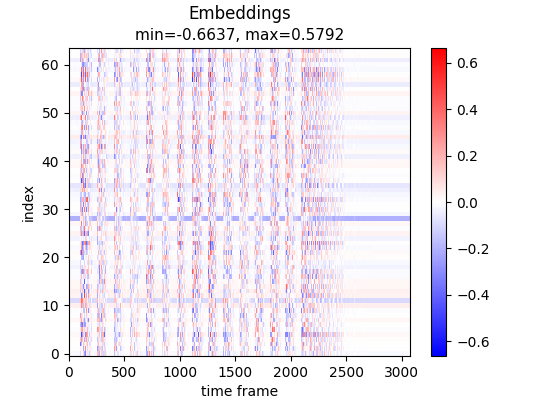

In [ ]:
print("Before:")
display(tokens_spectrogram_image(embeddings))

After:


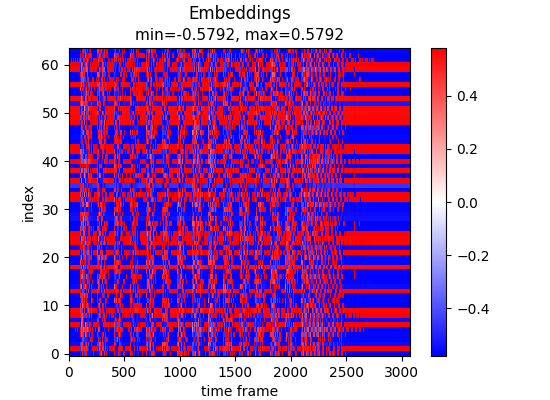

In [ ]:
print("After:")
display(tokens_spectrogram_image(z))

3D Point Clouds:

In [ ]:
print("Before:")
show_pca_point_cloud(embeddings, mode='lines+markers') 

Before:


In [ ]:
print("After:")
show_pca_point_cloud(z, mode='lines+markers') 

After:


<a id="decode"></a>
# $5.$ 🔊 Decode and Listen
Now we decode & listen to the embeddings that were the result of the mathemangling operation(s)

In [ ]:
demo_steps = 35 #@param {type:"slider", min:10, max:100, step:1}

fake_batches2 = sample(model.diffusion_ema, noise, demo_steps, 0, z)
audio_out2 = rearrange(fake_batches2, 'b d n -> d (b n)').cpu() # un-batch: Put the demos together
if np.abs(audio_out2.flatten()).max() >= 1.0:                   # let's go ahead and rescale to prevent clipping 
    audio_out2 = 0.99*audio_out2/np.abs(audio_out2.flatten()).max() 
playable_spectrogram(audio_out2, output_type='live')

Original Input Audio was (for comparison):

In [ ]:
playable_spectrogram(audio_in, output_type='live')

Let's look at spectrograms alone:

Before:


/fsx/shawley/envs/shazbot/lib/python3.8/site-packages/torchaudio/functional/functional.py:571: UserWarning:

At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.



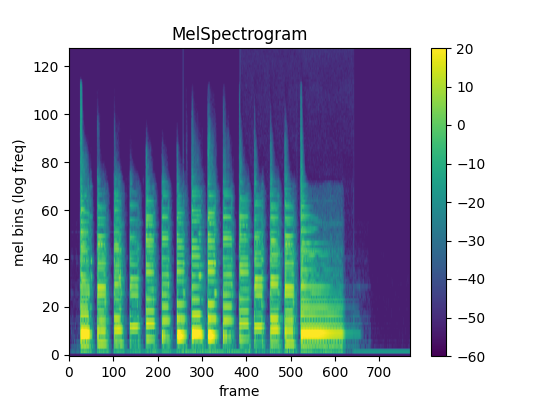

In [ ]:
print("Before:")
spec_graph = audio_spectrogram_image(audio_out.cpu(), justimage=False, db=False, db_range=[-60,20])
display(spec_graph)

After:


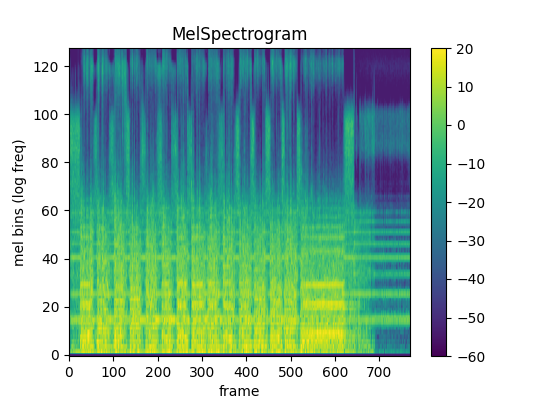

In [ ]:
print("After:")
spec_graph2 = audio_spectrogram_image(audio_out2, justimage=False, db=False, db_range=[-60,20])
display(spec_graph2)

In [ ]:
# @title (Optional) Re-amp your output?
#@markdown With re-amping, you create a feedback loop so you can go back up to "Mathemangle" to add more to your signal chain.

# @markdown (Note that this will overwrite your input embeddings, so we'll save a backup just in case you want to "undo")

re_amp = False  #@param {type:"boolean"}
if re_amp:
    backup, embeddings = embeddings.clone(), z 

<a id="share"></a>
# $6.$ ↗️ Share Your New Sounds 
...either alone as part of a song you made! [Harmonai](https://www.harmonai.org/) Play Discord has a [#show-and-tell](https://discord.com/channels/1001555636569509948/1013162448724951073) channel where you can post your Destructo creations! 

<a id="license"></a>
# $7.$ ⚖️ Licence
Sounds are all yours, period.  

As for the code, it is:



Licensed under the MIT License

Copyright (c) 2022 Scott H. Hawley 

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

-------
<a id="audalgeff"></a>
# $8.$ ❔ Afterword: Researching Audio-Algebra for Effects?

## Can We 1-Shot-Learn Audio Effects using These Embeddings? (Spoiler: No but let's try...)

Do embeddings store anything important, and can vectors in embedding-space be meaningfully used to model audio effects?

Language models showed that operations on embeddings of words (for well-trained masked language models) could produce "semantically meaningful" results, such as "king - man + woman = queen" or "japan - tokyo = germany - berlin". 

Can our model(s) do similar things for audio?  Here we'll subtract two (new) embeddings and add them to a third (your original input embedding).  What do we get? 

In what follows, you'll upload two "versions" of the same audio, with ("wet") and without ("dry") an effect applied (e.g. distortion).

> Will we get e.g. "wet_piano - dry_piano + dry_guitar = wet_guitar"? 

In the examples provided in `examples/`, we used an overdrive effect for "wet".  This is a nonlinear effect, so we might not expect a "linear addition rule" to work for this (spoiler: and we'd be correct), but let's try it anyway:

In [ ]:
effect = 'reverb'

In [ ]:
#@markdown Provide the full path of your audio files:

dry_name = 'examples/piano_dry.mp3'  #@param{type:"string"}
dry = load_audio(dry_name, sr=global_args.sample_rate)
if dry.shape[0] == 1: dry = torch.vstack((dry, dry))

wet_name = f'examples/piano_wet_{effect}.mp3' #@param{type:"string"}
wet = load_audio(wet_name, sr=global_args.sample_rate)
if wet.shape[0] == 1: wet = torch.vstack((wet, wet))

# let's make them the same size 
min_len = min(dry.shape[-1], wet.shape[-1])
dry, wet = dry[:,:min_len], wet[:,:min_len]

print(f"dry.shape = {dry.shape}, wet.shape = {wet.shape}")
print("dry:")
playable_spectrogram(dry, output_type='live')

In [ ]:
print("wet:")  
playable_spectrogram(wet, output_type='live')

In raw-audio space, the difference between these is:

In [ ]:
print("wet - dry (difference taken in raw audio domain):")  
playable_spectrogram(wet - dry, output_type='live')

....That includes a lot of the original "content".  One might hope that in embedding space, by "subtracting out the content" we might leave only the "audio effect" that makes up their difference.

In [ ]:
#@title Encode wet & dry, compute the difference

dry_reals = batch_it_crazy(dry, global_args.sample_size)
wet_reals = batch_it_crazy(wet, global_args.sample_size)

max_batch_size = 8
if dry_reals.size()[0] > max_batch_size:
    print(f"Warning: Due to CUDA memory limits, we're cutting you off at a batch size of {max_batch_size}")
    dry_reals = dry_reals[0:max_batch_size,:,:]
    wet_reals = wet_reals[0:max_batch_size,:,:]

print(f"dry_reals.shape = {demo_reals.shape}, wet_reals.shape = {wet_reals.shape}")

dry_embeddings, dry_noise = encode_it(dry_reals, model) 
wet_embeddings, wet_noise = encode_it(wet_reals, model) 
diff = wet_embeddings - dry_embeddings     ## this is "king - man"

print(f"Difference encoded to diff.  diff.shape =",diff.shape,", and noise.shape =",noise.shape)

dry_reals.shape = torch.Size([6, 2, 65536]), wet_reals.shape = torch.Size([4, 2, 65536])
Difference encoded to diff.  diff.shape = torch.Size([4, 64, 512]) , and noise.shape = torch.Size([6, 2, 65536])


In [ ]:
# @title 🔊 Appy difference to input audio, decode

# @markdown Time-average the difference in embeddings?
time_avg = False  #@param {type:"boolean"}

# @markdown Number of steps for diffusion reconstruction: 
demo_steps = 35 #@param {type:"slider", min:10, max:100, step:1}

z = embeddings.clone() # backup.clone()    # just in case we re-amped, go back to an earlier version

if time_avg: 
    diff = diff.mean(axis=-1)
else:
    # make sure embeddings and diff have the same length
    length_difference = z.shape[-1] - diff.shape[-1]
    if length_difference > 0:  # zero-pad the end of diff
        diff = torch.nn.functional.pad(diff,(length_difference,0,0,0,0,0), mode='constant')
    elif length_difference < 0: # truncate diff 
        diff = diff[:,:,:z.shape[-1]]
    
    diff = diff.mean(0) # average diff over batches, to allow broadcasting


# now apply the "learned effect"
z = z + diff   # woman + (king - man)  = ? (queen?)

# and decode
fake_batches2 = sample(model.diffusion_ema, noise, demo_steps, 0, z)
audio_out3 = rearrange(fake_batches2, 'b d n -> d (b n)').cpu() # un-batch: Put the demos together
if np.abs(audio_out3.flatten()).max() >= 1.0:                   # let's go ahead and rescale to prevent clipping 
    audio_out3 = 0.99*audio_out3/np.abs(audio_out3.flatten()).max() 
playable_spectrogram(audio_out3, output_type='live')

...not much of a success.  Not much change to the guitar, and some of the piano content is leaking in. 

If the same (real) effect is applied to the guitar (for realsies), we'd expect to have gotten this: 


In [ ]:
real_wet_guitar = load_audio(f'examples/guitar_wet_{effect}.mp3')
playable_spectrogram(real_wet_guitar, output_type='live')

### Conclusions? 
So, *for this particular embedding model*, we did not observe a "vector space" relation for a particular (time-dependent) audio effect.  Perhaps a different model would allow us to perform such an operation. 


Even with this model, we might still try to compute an "average" displacement (or perhaps somehow a nonlinear effect) in embedding space for certain effects, and see how well that works.  This is an active goal of the Audio Algebra research program.  We can try that with a dataset in another notebook. 

### What about using 'the trivial embedding'? 
Regarding the raw audio itself as a trivial embedding, what happens if we just do algebra on the audio samples?   Well, are samples aren't quite the same size but we can try...

In [ ]:
diff = (wet - dry).cpu()
minshape = min(diff.shape[-1], audio_out.shape[-1])
try_guitar_wet = diff[:,:minshape] + audio_out.cpu()[:,:minshape]
playable_spectrogram(try_guitar_wet, output_type='live')

lots more piano in that that when we used the embeddings.  So... hard to say what's going on.  Maybe using more examples, or a different effect than distortion, would be helpful. 